In [2]:
import pickle
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.metrics import AUC, Precision, Recall

In [3]:
# Tải data đã lưu
split_file = "splitted_data.pkl"
print("Tải dữ liệu đã lưu từ:", split_file)

with open(split_file, "rb") as f:
    data_splits = pickle.load(f)

# Lấy các tập dữ liệu từ dictionary
X_train = data_splits["X_train"]
X_val = data_splits["X_val"]
X_test = data_splits["X_test"]
y_train = data_splits["y_train"]
y_val = data_splits["y_val"]
y_test = data_splits["y_test"]
X_train_val = data_splits["X_train_val"]
y_train_val = data_splits["y_train_val"]

Tải dữ liệu đã lưu từ: splitted_data.pkl


In [4]:
# Kiểm tra phân phối của lớp
print("Phân phối lớp trong tập huấn luyện:")
unique, counts = np.unique(y_train_val, return_counts=True)
print(dict(zip(unique, counts)))
print(f"Tỷ lệ dữ liệu dương/âm: 1:{counts[0]/counts[1]:.2f}")

Phân phối lớp trong tập huấn luyện:
{0: 26815, 1: 169}
Tỷ lệ dữ liệu dương/âm: 1:158.67


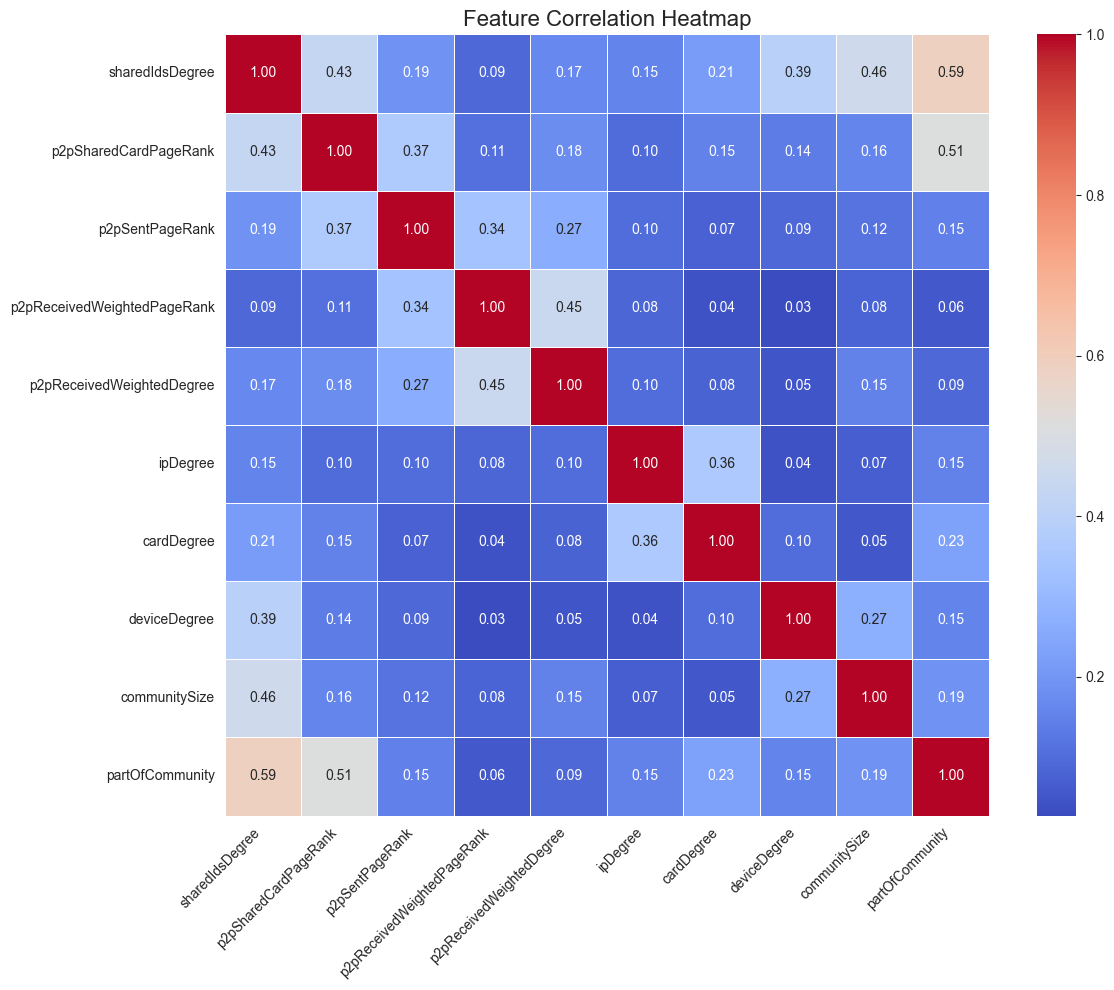

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính hệ số tương quan theo các cặp trong mọi cột bằng corr()
corr = X_train_val.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Lưu thành file PNG
plt.savefig('heatmap_x_train_val.png')

plt.show()

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        """
        Focal Loss cho bài toán phân loại nhị phân.
        y_true: Ground truth (0 hoặc 1)
        y_pred: Xác suất dự đoán (sigmoid output)
        """
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(K.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = alpha_factor * K.pow(1 - p_t, gamma)
        
        loss = -focal_weight * K.log(p_t)
        return K.mean(loss)
    
    return focal_loss_fixed

In [6]:
# Khởi tạo mô hình 
def create_model(input_dim, l2_lambda=0.001):
    model = Sequential([
        # Tầng đầu tiên với nhiều neuron hơn và regularization
        Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        # Tầng ẩn thứ hai
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.3),

        # Thêm một tầng ẩn nữa
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(0.2),

        # Tầng đầu ra
        Dense(1, activation='sigmoid')
    ])
 
    # Sử dụng optimizer Adam với learning rate thấp hơn
    optimizer = Adam(learning_rate=0.0005)
    
    # Compile với các metrics phù hợp cho dữ liệu không cân bằng
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        # loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )
    
    return model

In [7]:
# Tạo mô hình
improved_model = create_model(X_train.shape[1])

# In kiến trúc mô hình
improved_model.summary()

# Chuẩn bị callbacks
early_stop = EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 64)                

In [8]:
# Huấn luyện mô hình
improved_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=1024,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# Dự đoán xác suất trên tập test
y_pred_proba = improved_model.predict(X_test)

Epoch 1/100


20/20 - 3s - loss: 0.9860 - accuracy: 0.6203 - auc: 0.5958 - precision: 0.0091 - recall: 0.5512 - val_loss: 1.0437 - val_accuracy: 0.6607 - val_auc: 0.5811 - val_precision: 0.0100 - val_recall: 0.5476 - lr: 5.0000e-04 - 3s/epoch - 143ms/step
Epoch 2/100
20/20 - 0s - loss: 0.8724 - accuracy: 0.6526 - auc: 0.5555 - precision: 0.0076 - recall: 0.4173 - val_loss: 0.8237 - val_accuracy: 0.8449 - val_auc: 0.6067 - val_precision: 0.0136 - val_recall: 0.3333 - lr: 5.0000e-04 - 153ms/epoch - 8ms/step
Epoch 3/100
20/20 - 0s - loss: 0.8159 - accuracy: 0.7320 - auc: 0.5165 - precision: 0.0084 - recall: 0.3543 - val_loss: 0.7110 - val_accuracy: 0.9659 - val_auc: 0.6489 - val_precision: 0.0253 - val_recall: 0.1190 - lr: 5.0000e-04 - 219ms/epoch - 11ms/step
Epoch 4/100
20/20 - 0s - loss: 0.7652 - accuracy: 0.7907 - auc: 0.5333 - precision: 0.0072 - recall: 0.2362 - val_loss: 0.6507 - val_accuracy: 0.9787 - val_auc: 0.6319 - val_precision: 0.0278 - val_recall: 0.0714 - lr: 5.0000e-04 - 2

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
# Tìm ngưỡng tối ưu sử dụng precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
optimal_threshold_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_idx]

print(f"Ngưỡng dự đoán tối ưu: {optimal_threshold:.4f}")

# Áp dụng ngưỡng tối ưu
y_pred = (y_pred_proba > optimal_threshold).astype(int)

# Đánh giá mô hình
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Ngưỡng dự đoán tối ưu: 0.4727
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      6705
           1       0.03      0.19      0.05        42

    accuracy                           0.95      6747
   macro avg       0.51      0.57      0.51      6747
weighted avg       0.99      0.95      0.97      6747



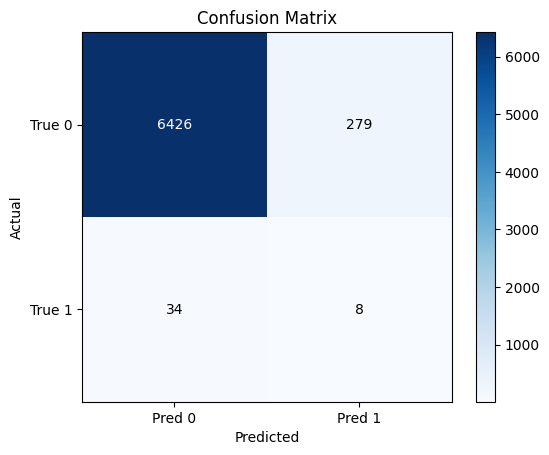

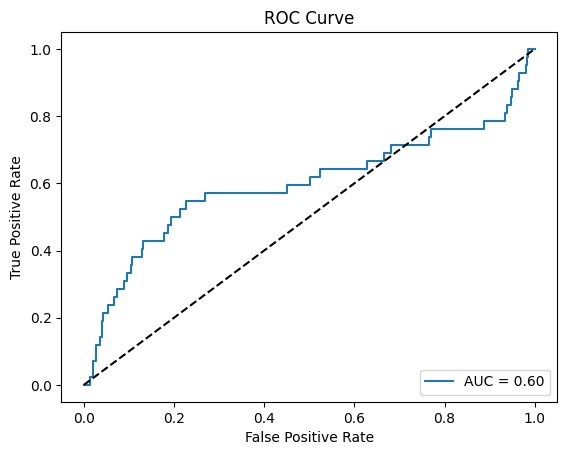

In [11]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)  
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set(
    xticks=[0,1], yticks=[0,1],
    xticklabels=['Pred 0','Pred 1'],
    yticklabels=['True 0','True 1'],
    title='Confusion Matrix',
    xlabel='Predicted', ylabel='Actual'
)
thresh = cm.max() / 2
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i,j],
                ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_proba) 
roc_auc      = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()